<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

# STA 208: Homework 1 (Do not distribute)

# Due 4/18/2018 in class and online by 10am

__Instructions:__ To make grading easier for the TAs please print out your homework and also submit it on canvas.  The canvas should include all of your code either in this notebook file, or a separate python file that is imported and ran in this notebook.  We should be able to open this notebook and run everything here by running the cells in sequence.  The written portions can be either done in markdown and TeX in new cells or written clearly by hand when you hand it in.

- Code should be well organized and documented
- All math should be clear and make sense sequentially
- When in doubt explain what is going on
- You will be graded on correctness of your math, code efficiency and succinctness, and conclusions and modelling decisions

__Exercise 1__ (20 pts)

Consider the binary classification setting where the training data is $x_i \in \mathbb R^p, y_i \in \{0,1\}, i=1,\ldots,n$ and recall the empirical risk (as a function of the predictor $g : \mathbb R^p \to \{0,1\}$),
$$
R_n(g) = \frac 1n \sum_{i=1}^n \ell(y_i, g(x_i)),
$$
and the true risk is 
$$
R(g) = \mathbb E \ell(Y,g(X))
$$
where $X,Y$ are drawn from their joint distribution $f_{X,Y}(x,y)$.

1. Suppose that the loss function is the Hamming loss, $\ell(y,\hat y) = 1\{ y \ne \hat y\}$.  What is the predictor that minimizes the True risk?  (Hint: derive an expression for this based on the joint distribution - you can use expressions involving conditional probabilities.)
2. The predictor above is called the Bayes rule.  For the Hamming loss, write an expression for the true risk of the Bayes rule, this is the irreducible error.
3. Suppose that we know that the Bayes rule can be written in the form, 
$$
h(x) = 1\{ x_j > 0 \}, 
$$
for some $j = 1,\ldots,p$, but we don't know which one.  Now using the empirical risk, what is a reasonable classification algorithm (Hint: you can think of finding a good classifier as a problem of finding $j$).  Describe the fit and predict methods. 
4. Suppose that I told you that for any fixed $g$ the following probability bound holds (from Hoeffding's inequality)
$$
\mathbb P \left\{ |R_n(g) - R(g)| > t \right\} \le 2 \exp \left( - 2 n t^2 \right).
$$
How many samples would I need to get a classifier $\hat g$, from the previous question, such that 
$$
\mathbb P \left\{ R(\hat g) < R(h) + 0.1 \right\} \ge 0.95.
$$
(Hint: use the union bound)

**Exercise 1 Answers**: Please see `hw1_writeup.pdf`

__Exercise 2__ (20 pts)

Consider the regression setting in which $x_i \in \mathbb R^p$ and $y_i \in \mathbb R$, for $i=1,\ldots,n$ and $p < n$.

1. For a given regressor, let $\hat y_i$ be prediction given $x_i$, and $\hat y$ be the vector form.  Show that both linear regression and k-nearest neighbors can be written in the form
$$
\hat y = H y,
$$
where $H$ is dependent on $X$ (the matrix of where each row is $x_i$).  Give a clear expression for $H$.
2. By modifying the matrix $H$, how can we ensure that a given sample is not used as a k nearest neighbor.  Derive an expression for the leave-one-out cross validated square error based on this.
3. For linear regression, let $X = U D V^\top$ be the singular value decomposition where $U$ is $n \times p$, and $V, D$ is $p \times p$ ($D$ is diagonal). Derive an expression for the OLS coefficients $\beta = A b$ such that $A$ is $p \times p$ and depends on $V$ and $D$, and $b$ is a $p$ vector and does not depend on $D$.  Describe a fit method that precomputes these quantities separately, and describe a predict method.
4. Consider a regressor that performs OLS using the SVD above, but every instance of D will only use the largest $r$ values on the diagonal (all others are set to 0).  Call this new matrix $D_r$ ($r < p$).  Given that you have computed $b$ already, how could you make a method `change_rank` that recomputes $A$ with $D_r$ instead of $D$?  What is its computational complexity (it should not depend on n)?

**Exercise 2 Answers**: Please see `hw1_writeup.pdf`

__Exercise 3__ (30 pts)

We call the method that zeros out all but $r$ singular values in OLS, singular value regression.  Implement the singular value regressor as a sklearn style class below.  Test it by simulating the training and test data from the `gen_LR_data` function below and calculate the average square error on the test set.  Do this for each choice of `r` in the fit function.

In [58]:
import numpy as np
from scipy.linalg import svd
from sklearn.preprocessing import scale

In [59]:
class SingularValueRegressor:
    """
    : A regression object that uses the SVD to fit and predict
    : Init: specify rank r
    : .fit: solve the SVD of X and precompute beta
    : .predict: Return y hat for X_test
    """
    
    def __init__(self, r):
        """
        : Store the rank
        """
        self.r = r
        self.b = None
        self.b_r = None
        self.A = None
        self.A_r = None
        self.beta = None
        
    def fit(self, X, y):
        """
        : Computes and stores the SVD (use scipy.linalg.svd)
        : Computes beta for rank r singular value regression
        """
        N, p = X.shape
        X_scaled = scale(X)
        U, D, Vh = svd(X_scaled)
        self.A = Vh.T.dot(np.diag(np.reciprocal(D)))
        self.b = U.T.dot(y)
        self.change_rank(self.r)
        
    def predict(self, X_test):
        """
        : Outputs the predicted y given the predictors X_test
        """
        X_test_scaled = scale(X_test)
        return X_test_scaled.dot(self.beta)
        
    def change_rank(self, r):
        """
        : Assumes that the SVD has been computed and uses it to change the rank; after
        : running the new regressor object should be as if we fit with the new rank r
        """
        self.r = r
        self.A_r = self.A[:, :r]  # take first r columns
        self.b_r = self.b[:r]
        self.beta = self.A_r.dot(self.b_r)

In [60]:
def gen_LR_data(r = 10, p = 20, n = 100):
    """
    : generate data from an approx low rank regression model
    """
    alpha = np.random.chisquare(1,size = (p,r)) #X coefficients
    Z = np.random.normal(size=(n,r)) #X covariates
    beta = np.random.normal(size = r) #reg covs
    mu = Z @ beta #hidden mean
    Xmean = Z @ alpha.T #random transformation of Z
    X = Xmean + np.random.normal(0,.5,size=(n,p)) #add noise - not exactly low rank
    X_test = Xmean + np.random.normal(0,.5,size=(n,p))
    y = mu + np.random.normal(0,1,size=(n))
    y_test = mu + np.random.normal(0,1,size=(n))
    return (X,y,X_test,y_test)

In [61]:
X,y,X_test,y_test = gen_LR_data()

In [62]:
for v in ['X', 'y', 'X_test', 'y_test']:
    print(v, 'shape:', eval(v).shape)

X shape: (100, 20)
y shape: (100,)
X_test shape: (100, 20)
y_test shape: (100,)


In [63]:
model = SingularValueRegressor(X.shape[1])

In [64]:
model.fit(X, y)

In [65]:
from sklearn.metrics import mean_squared_error

In [66]:
r_range = range(1, X.shape[1]+1)
MSE = []

for r in r_range:
    model.change_rank(r)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y, y_pred)
    MSE.append(mse)

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0,0.5,'mean square error')

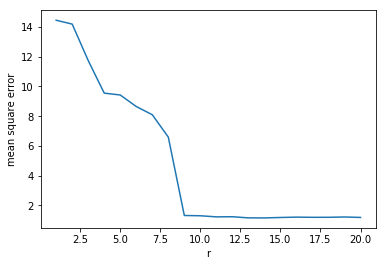

In [68]:
plt.plot(r_range, MSE, label='MSE')
plt.xlabel('r')
plt.ylabel('mean square error')

__Exercise 4__ (30 pts)

The dataset in the hw1 directory has a Y variable, 7 predictor variables (X1 - X7).  Using sklearn and the class that you constructed above, compare ridge regression, OLS, kNN, and SVRegression.  Compare and tune the methods using appropriate cross validation.  Comment on the tuning of each parameter in ridge, kNN, and SVRegression in markdown.  Be sure to standardize the X variables first and decide how to deal with NAs.  Feel free to use the LOO method from lab 1.

In [69]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor

In [70]:
data_mat = pd.read_csv('hw1_data.csv')
data_mat.head()

,Y,X1,X2,X3,X4,X5,X6,X7
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0


**Exercise 4 Answers**

In [80]:
data_mat.shape

(398, 8)

Check missing values

In [82]:
data_mat.isnull().sum()

Y     0
X1    0
X2    0
X3    6
X4    0
X5    0
X6    0
X7    0
dtype: int64

In [83]:
data_mat[data_mat.X3.isnull()]

,Y,X1,X2,X3,X4,X5,X6,X7
32,25.0,4.0,98.0,NaN,2046.0,19.0,71.0,1.0
126,21.0,6.0,200.0,NaN,2875.0,17.0,74.0,1.0
330,40.9,4.0,85.0,NaN,1835.0,17.3,80.0,2.0
336,23.6,4.0,140.0,NaN,2905.0,14.3,80.0,1.0
354,34.5,4.0,100.0,NaN,2320.0,15.8,81.0,2.0
374,23.0,4.0,151.0,NaN,3035.0,20.5,82.0,1.0


Drop missing observations

In [84]:
data_mat.dropna(inplace=True)
data_mat.isnull().sum()

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
dtype: int64

In [85]:
y = data_mat['Y'].values
X = scale(data_mat.loc[:, 'X1':'X7'].as_matrix())

In [79]:
X.shape

(398, 7)